# 🏥 Healthcare Insurance Cost Analysis  
## 📊 Notebook 10 – Baselines and Clustering

| Feild | Description |
|-------|-------------|
|**Author:** | Robert Steven Elliott  |
|**Course:** | Code Institute – Data Analytics with AI Bootcamp |  
|**Project Type:** | Individual Formative Project  | 
|**Date:** | December 2025  |

---

## Change Working Directory

In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))
print("✅ Working directory set to project root:", PROJECT_ROOT)

✅ Working directory set to project root: /home/robert/Projects/health-insurance-cost-analysis


## Load Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (silhouette_score, 
                             mean_absolute_error, 
                             root_mean_squared_error, 
                             r2_score)
from sklearn.pipeline import Pipeline
from utils.data_handler import load_data, data_overview, clean_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [3]:
input_path = PROJECT_ROOT / "data" / "final" / "insurance_final.csv"

df = load_data(input_path)
data_overview(df)
df = clean_data(df, categorical_cols=['sex', 'smoker', 'region'])
selected_features = [
    "age", "bmi", "children", "charges",
    "sex", "smoker", "region"
]
df_selected = df[selected_features]

DataFrame Shape: (1337, 10)

Data Types:
 age                       int64
sex                      object
bmi                     float64
children                  int64
smoker                   object
region                   object
charges                 float64
bmi_category             object
age_group                object
family_size_category     object
dtype: object

Missing Values:
 age                     0
sex                     0
bmi                     0
children                0
smoker                  0
region                  0
charges                 0
bmi_category            0
age_group               0
family_size_category    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1337 non-null   int64  
 1   sex                   1337 non-null   object 
 2   bmi              

## Preprocess (numeric scaling + one-hot encoding)

In [4]:
NUM_COLS = ["age", "bmi", "children"]
CAT_COLS = ["sex", "smoker", "region"]
TARGET = "charges"

X = df[NUM_COLS + CAT_COLS].copy()
y = df[TARGET].copy()

# Log-transform target (typical for charges)
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), NUM_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
    ],
    remainder="drop",
)

X_train_prep = preprocess.fit_transform(X_train)
X_test_prep = preprocess.transform(X_test)

print("Prepared train shape:", X_train_prep.shape)


Prepared train shape: (1069, 11)


## Baseline regression models

In [5]:
lin = LinearRegression()
lin.fit(X_train_prep, y_train)
pred_lin = lin.predict(X_test_prep)

# Random Forest baseline (works on sparse but may be slower)
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_prep, y_train)
pred_rf = rf.predict(X_test_prep)


In [6]:
def evaluate_log_target(y_true_log, y_pred_log, label=""):
    # Metrics on log scale
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    rmse_log = root_mean_squared_error(y_true_log, y_pred_log)
    r2 = r2_score(y_true_log, y_pred_log)

    # Convert back to original scale for interpretability
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    print(f"== {label} ==")
    print(f"MAE (log):  {mae_log:,.4f}")
    print(f"RMSE (log): {rmse_log:,.4f}")
    print(f"R² (log):   {r2:,.4f}")
    print(f"MAE:        £{mae:,.2f}")
    print(f"RMSE:       £{rmse:,.2f}")

In [7]:
evaluate_log_target(y_test, pred_lin, label="Linear Regression (baseline)")
evaluate_log_target(y_test, pred_rf, label="Random Forest (baseline)")

== Linear Regression (baseline) ==
MAE (log):  0.2607
RMSE (log): 0.3978
R² (log):   0.8295
MAE:        £3,755.92
RMSE:       £7,197.03
== Random Forest (baseline) ==
MAE (log):  0.1908
RMSE (log): 0.3704
R² (log):   0.8522
MAE:        £2,045.28
RMSE:       £4,353.50


## 4. Clustering (KMeans)

In [8]:
k_values = range(2, 11)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_train_prep)
    sil = silhouette_score(X_train_prep, labels)
    sil_scores.append(sil)

best_k = int(k_values[int(np.argmax(sil_scores))])
print("Best k by silhouette (train):", best_k)
print("Silhouette scores:", dict(zip(k_values, [round(s,4) for s in sil_scores])))

Best k by silhouette (train): 3
Silhouette scores: {2: 0.1725, 3: 0.1834, 4: 0.1681, 5: 0.1487, 6: 0.1384, 7: 0.1418, 8: 0.1414, 9: 0.1365, 10: 0.1436}


## Apply Knee Detection

In [9]:
k_list = list(k_values)
sil_array = np.asarray(sil_scores)

locator = KneeLocator(
    k_list,
    sil_array,
    curve="concave",       # silhouette usually peaks then flattens
    direction="increasing"
)

print("Knee location:", locator.knee)
print("All attributes:", vars(locator))

Knee location: 3
All attributes: {'x': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'y': array([0.17245001, 0.18342884, 0.16814552, 0.14868709, 0.13836561,
       0.14183798, 0.14137203, 0.13647911, 0.14358347]), 'curve': 'concave', 'direction': 'increasing', 'N': 9, 'S': 1.0, 'all_knees': {np.int64(3)}, 'all_norm_knees': {np.float64(0.125)}, 'all_knees_y': [np.float64(0.18342883847528893)], 'all_norm_knees_y': [np.float64(1.0)], 'online': False, 'polynomial_degree': 7, 'Ds_y': array([0.17245001, 0.18342884, 0.16814552, 0.14868709, 0.13836561,
       0.14183798, 0.14137203, 0.13647911, 0.14358347]), 'x_normalized': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]), 'y_normalized': array([0.76615776, 1.        , 0.67447478, 0.26002228, 0.04018127,
       0.11414046, 0.10421616, 0.        , 0.15131826]), 'y_difference': array([ 0.76615776,  0.875     ,  0.42447478, -0.11497772, -0.45981873,
       -0.51085954, -0.64578384, -0.875     , -0.84868174]), 'x_difference': 

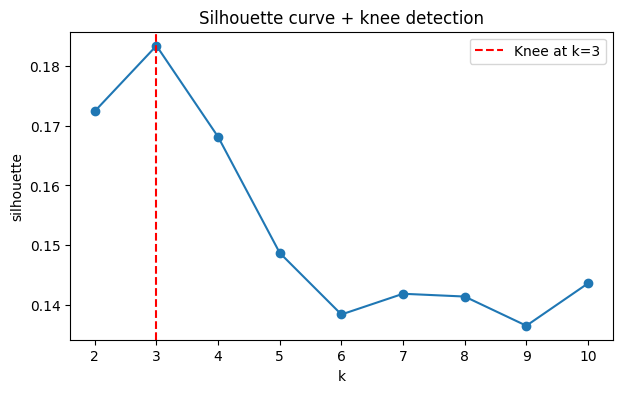

In [10]:
plt.figure(figsize=(7,4))
plt.plot(k_list, sil_array, marker="o")
plt.axvline(locator.knee, linestyle="--", color="red", label="Knee at k={}".format(locator.knee))
plt.title("Silhouette curve + knee detection")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.legend()
plt.show()

## Fit model

In [11]:
km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
train_clusters = km.fit_predict(X_train_prep)

df_train = X_train.copy()
df_train["charges_log"] = y_train.values
df_train["cluster"] = train_clusters

display(df_train.groupby("cluster").agg(
    count=("cluster","size"),
    age_mean=("age","mean"),
    bmi_mean=("bmi","mean"),
    children_mean=("children","mean"),
    smoker_rate=("smoker", lambda s: (s=="yes").mean()),
    charges_median=("charges_log", lambda v: float(np.expm1(np.median(v)))),
).sort_values("charges_median", ascending=False))

,count,age_mean,bmi_mean,children_mean,smoker_rate,charges_median
cluster,,,,,,
2,364,52.673077,32.123709,0.480769,0.153846,11483.806983
1,305,40.386885,30.453508,2.662295,0.222951,9225.256400
0,400,26.030000,29.165913,0.430000,0.225000,3939.385403


## PCA visualisation of clusters

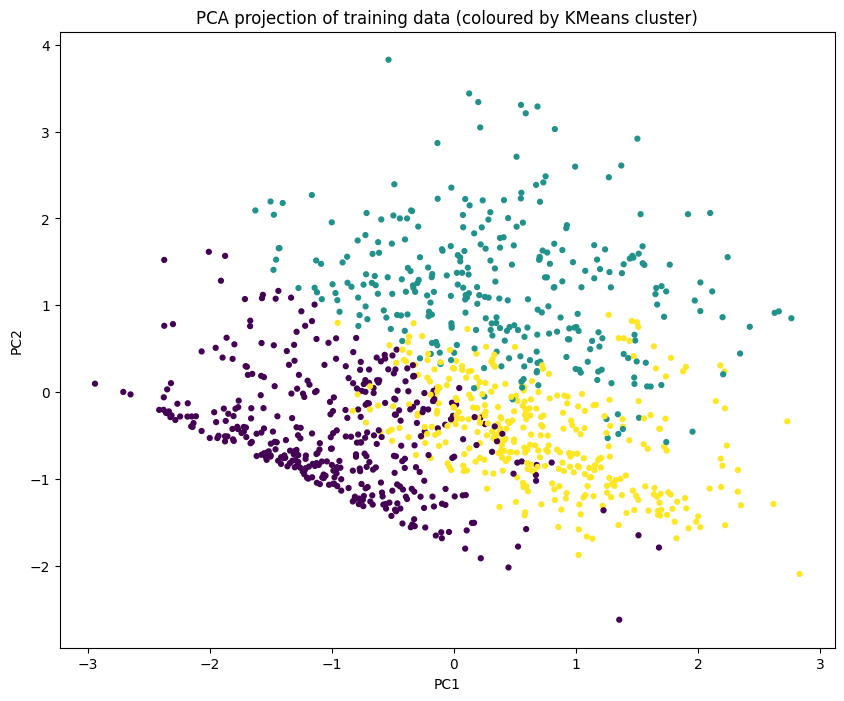

Explained variance ratio: [0.2504925  0.22018213]


In [12]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_train_prep.toarray() if hasattr(X_train_prep, "toarray") else X_train_prep)

plt.figure(figsize=(10,8))
plt.scatter(X2[:,0], X2[:,1], c=train_clusters, s=12)
plt.title("PCA projection of training data (coloured by KMeans cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)